# Prediksi Gaji JobStreet - Analisis Data Mining
## Menggunakan Metodologi CRISP-DM

**Cross-Industry Standard Process for Data Mining (CRISP-DM)** adalah metodologi standar industri untuk proyek data mining yang terdiri dari 6 fase:

1. **Business Understanding** - Memahami tujuan bisnis dan kebutuhan
2. **Data Understanding** - Eksplorasi dan pemahaman data
3. **Data Preparation** - Persiapan dan pembersihan data
4. **Modeling** - Pembangunan model prediktif
5. **Evaluation** - Evaluasi performa model
6. **Deployment** - Implementasi model untuk penggunaan

---

## 1. Business Understanding

### Tujuan Bisnis
Proyek ini bertujuan untuk mengembangkan model prediksi gaji berdasarkan data lowongan pekerjaan dari JobStreet. Model ini akan membantu:
- **Job seekers**: Memperkirakan gaji yang realistis untuk posisi tertentu
- **HR/Recruiter**: Menentukan range gaji yang kompetitif
- **Perusahaan**: Benchmarking gaji berdasarkan industri dan kategori pekerjaan

### Masalah Bisnis
- Ketidakpastian dalam menentukan gaji yang tepat untuk posisi tertentu
- Kesenjangan informasi antara ekspektasi pelamar dan penawaran perusahaan
- Kebutuhan untuk standardisasi gaji berdasarkan kualifikasi dan kategori pekerjaan

### Kriteria Sukses
- Model dapat memprediksi gaji dengan akurasi tinggi (R² > 0.7)
- RMSE yang rendah untuk prediksi yang presisi
- Model yang dapat diterapkan untuk berbagai kategori pekerjaan

---

In [66]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import joblib


## 2. Data Understanding

### Import Library
Pada tahap ini, kita akan melakukan eksplorasi data untuk memahami karakteristik dataset JobStreet yang akan digunakan untuk membangun model prediksi gaji.

### Data Preparation

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3200 entries, 0 to 3199
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Kategori_Lowongan   3200 non-null   object 
 1   Pekerjaan Lowongan  3200 non-null   object 
 2   Title               3200 non-null   object 
 3   Posisi              3200 non-null   object 
 4   Gaji                3200 non-null   object 
 5   Gaji Min            1200 non-null   float64
 6   Gaji Max            1200 non-null   float64
 7   Kualifikasi         3200 non-null   object 
 8   Tahun Pengalaman    52 non-null     float64
 9   Umur                42 non-null     float64
 10  Pendidikan          120 non-null    object 
 11  Skill               377 non-null    object 
 12  Link                3200 non-null   object 
dtypes: float64(4), object(9)
memory usage: 325.1+ KB
None
           Gaji Min      Gaji Max  Tahun Pengalaman       Umur
count  1.200000e+03  1.200000e+03   

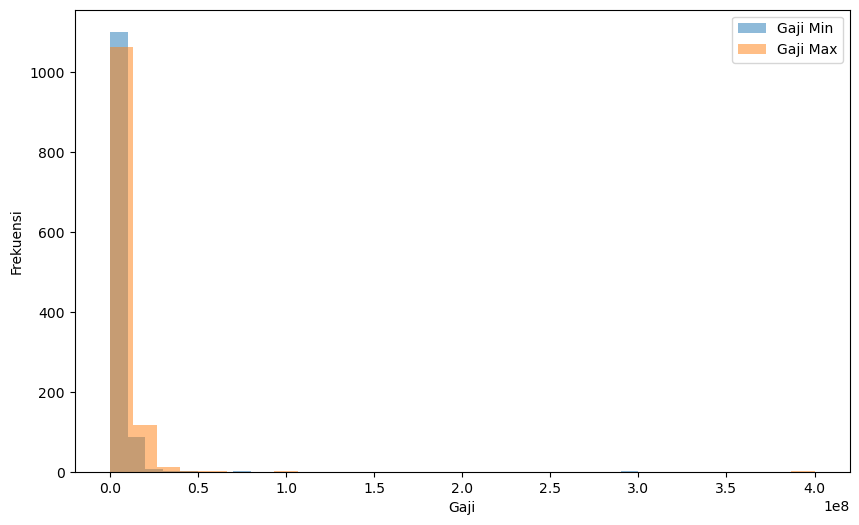

Kategori_Lowongan        0
Pekerjaan Lowongan       0
Title                    0
Posisi                   0
Gaji                     0
Gaji Min              2000
Gaji Max              2000
Kualifikasi              0
Tahun Pengalaman      3148
Umur                  3158
Pendidikan            3080
Skill                 2823
Link                     0
dtype: int64


In [67]:
df = pd.read_csv('jobstreet_jobs_cleaned_with_category.csv')

print(df.info())
print(df.describe())

# Distribusi gaji
plt.figure(figsize=(10, 6))
plt.hist(df['Gaji Min'].dropna(), bins=30, alpha=0.5, label='Gaji Min')
plt.hist(df['Gaji Max'].dropna(), bins=30, alpha=0.5, label='Gaji Max')
plt.xlabel('Gaji')
plt.ylabel('Frekuensi')
plt.legend()
plt.show()

# Missing values
print(df.isnull().sum())

### Eksplorasi Data
Melakukan eksplorasi awal untuk memahami struktur data, distribusi variabel, dan mengidentifikasi masalah data seperti missing values.

In [68]:
df['Gaji Min'] = df.groupby('Kategori_Lowongan')['Gaji Min'].transform(lambda x: x.fillna(x.median()))
df['Gaji Max'] = df.groupby('Kategori_Lowongan')['Gaji Max'].transform(lambda x: x.fillna(x.median()))

df = df.dropna(subset=['Gaji Min', 'Gaji Max'])

## 3. Data Preparation

### Penanganan Missing Values
Mengisi missing values menggunakan median berdasarkan kategori pekerjaan untuk mempertahankan karakteristik data.

In [69]:
df['Gaji_Rata'] = (df['Gaji Min'] + df['Gaji Max']) / 2

df['Jumlah_Skill'] = df['Skill'].apply(lambda x: len(str(x).split(',')))
df['Pendidikan_Encoded'] = df['Pendidikan'].map({'SMA': 0, 'D3': 1, 'S1': 2, 'S2': 3, 'S3': 4}).fillna(-1)

### Feature Engineering
Membuat fitur-fitur baru yang akan membantu model dalam memprediksi gaji:
- **Gaji_Rata**: Rata-rata dari gaji minimum dan maksimum
- **Jumlah_Skill**: Menghitung jumlah skill yang diperlukan
- **Pendidikan_Encoded**: Encoding level pendidikan

In [70]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)
kategori_encoded = encoder.fit_transform(df[['Kategori_Lowongan']])

encoded_df = pd.DataFrame(
    kategori_encoded, 
    columns=encoder.get_feature_names_out(['Kategori_Lowongan'])
)

df = pd.concat([df, encoded_df], axis=1)

### Encoding Variabel Kategorikal
Menggunakan One-Hot Encoding untuk mengkonversi variabel kategorikal (Kategori_Lowongan) menjadi format numerik yang dapat diproses oleh model machine learning.

In [71]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


### Persiapan Dataset untuk Modeling
Mempersiapkan fitur (X) dan target variable (y) untuk training model, kemudian membagi data menjadi training dan testing set.

In [ ]:
# Define feature variables (X) and target variable (y)
feature_columns = ['Jumlah_Skill', 'Pendidikan_Encoded'] + list(encoded_df.columns)
X = df[feature_columns]
y = df['Gaji_Rata']

print(f"Feature matrix shape: {X.shape}")
print(f"Target variable shape: {y.shape}")
print(f"Feature columns: {feature_columns}")

In [72]:
print("Before handling:")
print(f"NaN in y_train: {y_train.isna().sum()}")
print(f"Inf in y_train: {np.isinf(y_train).sum()}")

train_mask = ~(y_train.isna() | np.isinf(y_train))
test_mask = ~(y_test.isna() | np.isinf(y_test))

X_train = X_train[train_mask]
y_train = y_train[train_mask]
X_test = X_test[test_mask]
y_test = y_test[test_mask]

print("\nAfter handling:")
print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")


Before handling:
NaN in y_train: 15
Inf in y_train: 0

After handling:
Train shape: (2544, 64)
Test shape: (634, 64)


## 4. Modeling

### Data Cleaning
Sebelum membangun model, kita perlu membersihkan data dari NaN dan infinite values yang dapat mengganggu proses training.

In [79]:
models = {
    'XGBoost': {
        'model': XGBRegressor(random_state=42),
        'params': {
            'n_estimators': [100, 150],
            'learning_rate': [0.05, 0.1],
            'max_depth': [3, 5],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0]
        }
    },
    'RandomForest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'n_estimators': [100, 150],
            'max_depth': [None, 5, 10],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
    }

}

for name, config in models.items():
    print(f"\nTraining {name}...")
    model = config['model']
    params = config['params']
    
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=params,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    
    y_pred_train = best_model.predict(X_train)
    y_pred_test = best_model.predict(X_test)
    
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    
    # Store results
    best_models[name] = best_model
    results.append({
        'Model': name,
        'Best Params': grid_search.best_params_,
        'RMSE Train': rmse_train,
        'RMSE Test': rmse_test,
        'R2 Train': r2_train,
        'R2 Test': r2_test
    })
    
    print(f"{name} completed!")
    print(f"Best params: {grid_search.best_params_}")
    print(f"Test RMSE: {rmse_test:.2f}, R2: {r2_test:.4f}")



Training XGBoost...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
XGBoost completed!
Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
Test RMSE: 13909247.98, R2: -0.0021

Training RandomForest...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
RandomForest completed!
Best params: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 150}
Test RMSE: 13902771.78, R2: -0.0012


### Model Training dan Hyperparameter Tuning
Melakukan training dan optimisasi hyperparameter untuk berbagai algoritma machine learning menggunakan Grid Search Cross-Validation.

In [ ]:
# Initialize storage for models and results
best_models = {}
results = []

In [80]:
results_df = pd.DataFrame(results)
print("\nModel Comparison:")
print(results_df[['Model', 'RMSE Test', 'R2 Test']])



Model Comparison:
          Model     RMSE Test   R2 Test
0       XGBoost  1.390925e+07 -0.002119
1  RandomForest  1.390277e+07 -0.001186
2       XGBoost  1.390925e+07 -0.002119
3  RandomForest  1.390277e+07 -0.001186


## 5. Evaluation

### Model Comparison
Membandingkan performa berbagai model untuk memilih model terbaik.


Top 10 Features:
                              Feature  Importance
2                        Jumlah_Skill    0.311938
39     Kategori_Lowongan_Nutritionist    0.172876
32          Kategori_Lowongan_Lainnya    0.106849
23          Kategori_Lowongan_Finance    0.059924
51            Kategori_Lowongan_Sales    0.040890
48  Kategori_Lowongan_Quality Control    0.038202
36       Kategori_Lowongan_Management    0.027638
19         Kategori_Lowongan_Database    0.026949
22            Kategori_Lowongan_Event    0.026790
1                  Pendidikan_Encoded    0.019888


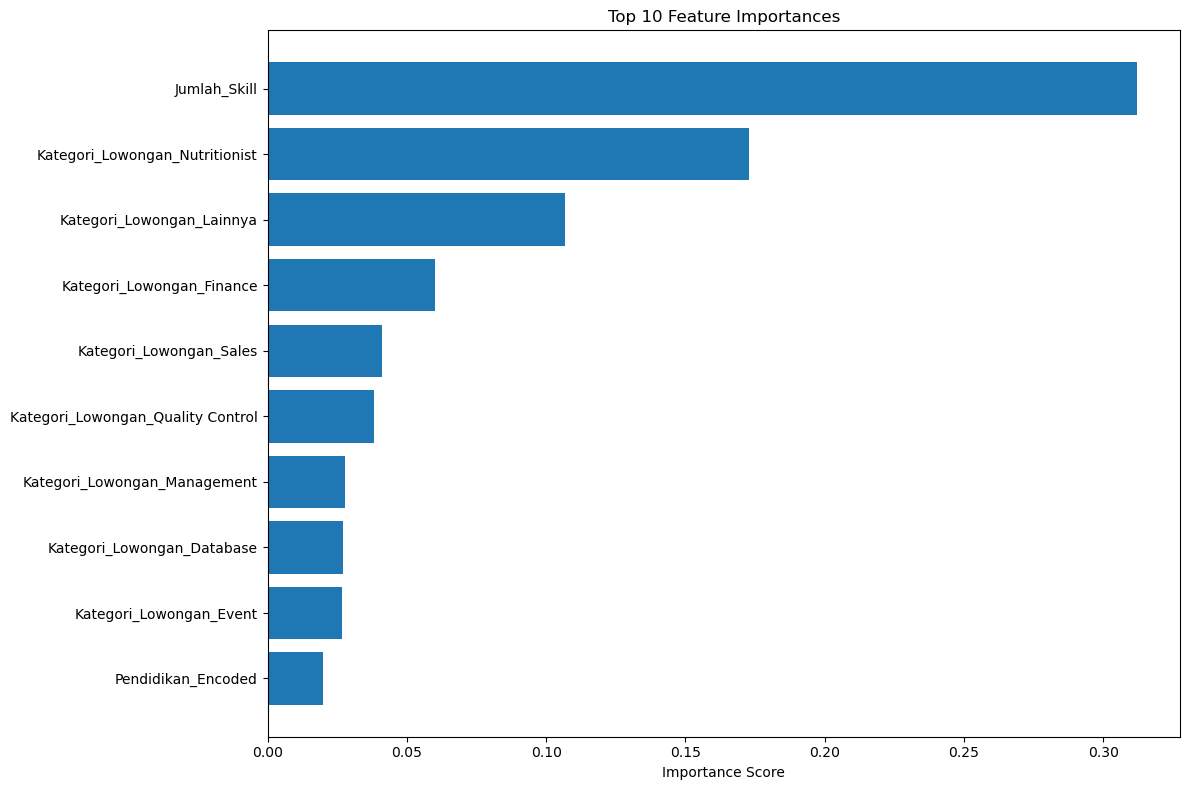

In [82]:
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    features = X.columns
    
    # Create DataFrame for feature importances
    feature_importances = pd.DataFrame({
        'Feature': features,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    print("\nTop 10 Features:")
    print(feature_importances.head(10))
    
    # Plot feature importances
    plt.figure(figsize=(12, 8))
    plt.barh(feature_importances['Feature'].head(10)[::-1], 
             feature_importances['Importance'].head(10)[::-1])
    plt.title('Top 10 Feature Importances')
    plt.xlabel('Importance Score')
    plt.tight_layout()
    plt.savefig('feature_importances.png', dpi=300)
    plt.show()


### Pemilihan Model Terbaik dan Feature Importance
Memilih model dengan performa terbaik dan menganalisis fitur-fitur yang paling penting dalam prediksi gaji.

In [ ]:
# Select the best model based on test R2 score
best_model_name = results_df.loc[results_df['R2 Test'].idxmax(), 'Model']
best_model = best_models[best_model_name]

print(f"Best Model: {best_model_name}")
print(f"Best R2 Score: {results_df['R2 Test'].max():.4f}")
print(f"Best RMSE: {results_df.loc[results_df['R2 Test'].idxmax(), 'RMSE Test']:.2f}")

In [83]:
joblib.dump(best_model, 'best_salary_predictor.pkl')
print("Best model saved as 'best_salary_predictor.pkl'")


Best model saved as 'best_salary_predictor.pkl'


## 6. Deployment

### Model Saving
Menyimpan model terbaik untuk implementasi dan penggunaan selanjutnya.

In [86]:
y_pred_final = best_model.predict(X_test)
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred_final))
final_r2 = r2_score(y_test, y_pred_final)
print("\nFinal Model Performance:")
print(f"RMSE on Test Set: {final_rmse:.2f}")
print(f"R2 on Test Set: {final_r2:.4f}")



Final Model Performance:
RMSE on Test Set: 13902771.78
R2 on Test Set: -0.0012


### Evaluasi Final Model
Evaluasi performa akhir model terbaik yang telah disimpan.

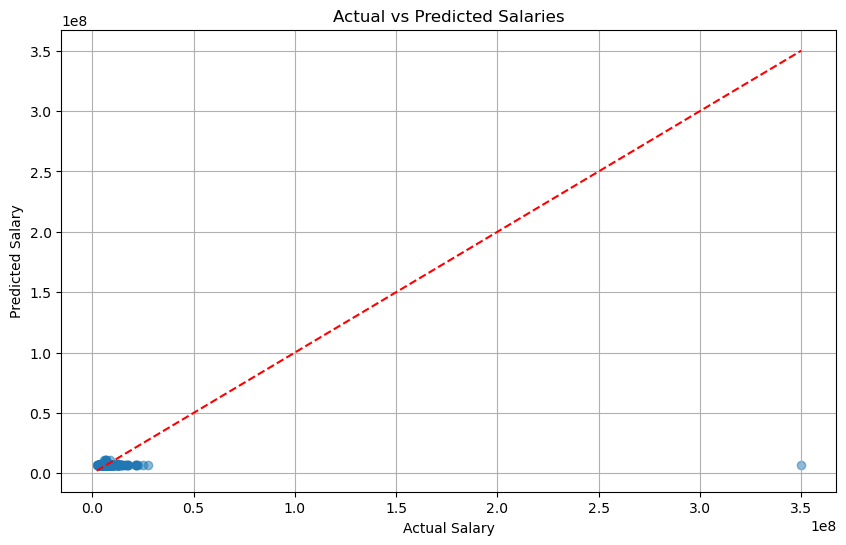

In [87]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_final, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Actual vs Predicted Salaries')
plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.grid(True)
plt.savefig('actual_vs_predicted.png', dpi=300)
plt.show()


### Visualisasi Hasil Prediksi
Membuat scatter plot untuk membandingkan nilai actual vs predicted untuk melihat seberapa baik model melakukan prediksi.

In [ ]:
# Import missing metric
from sklearn.metrics import mean_absolute_error

# Simpan metrik evaluasi
metrics = {
    'best_model': best_model_name,
    'r2': final_r2,
    'rmse': final_rmse,
    'mae': mean_absolute_error(y_test, y_pred_final),
    'test_size': len(y_test),
    'error_dist': (y_pred_final - y_test).tolist(),
    'feature_importances': feature_importances.to_dict() if 'feature_importances' in locals() else None
}
joblib.dump(metrics, 'model_metrics.pkl')

# Simpan daftar kolom yang digunakan
joblib.dump(X_train.columns.tolist(), 'model_columns.pkl')

print("Model dan metrik berhasil disimpan!")

['model_columns.pkl']